# NAIRU Models

(Non-accelerating inflation rate of unemployment)

## Acknowledgements

This work has drawn on ideas and approaches in the following:

https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf

https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

https://github.com/MacroDave/NAIRU

https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm  


In [2]:
# local imports
from abs_data_capture import (
    get_abs_series, 
)
from rba_data_capture import (
    get_data_table_labels,
    get_data,
)

## Data capture

Get the input data, map to quarterly where needed, diff where needed

In [3]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of 
    the three months in each quarter. Ignore quarters with less than 
    three months data. Drop NA items."""

    return (
        data
        .groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(['mean', 'count'])
        .apply(lambda x: x['mean'] if x['count'] == 3 else np.nan, axis=1)
        .dropna()
    )


#### Inflation

In [4]:
# inflation
inflation_meta, inflation = get_abs_series(cat_id="6401.0", series_ids=["A3604510W", "A2325850V"])
headline = inflation["A2325850V"].dropna()  # Q/Q percent change, original series
trimmed_mean = inflation["A3604510W"].dropna()  # Q/Q percent change, seasonally adjusted
Δρ = trimmed_mean
Δρ_1 = Δρ.shift(periods=1).dropna()
Δρ_2 = Δρ_1.shift(periods=1).dropna()
Δρ_3 = Δρ_1.shift(periods=1).dropna()


#### Inflation expectations (mix of real and synthetic data)

Missing values in bond yield:  PeriodIndex(['2013Q2'], dtype='period[Q-DEC]')


<Axes: title={'center': 'QonQ Inflation v Expectations'}>

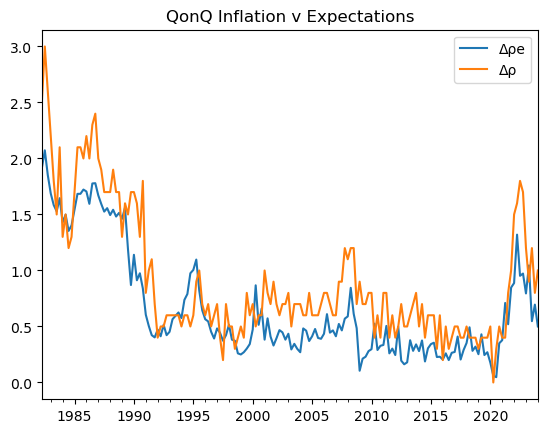

In [5]:
# inflation expectations from survey
g3_meta, g3 = get_data("Inflation Expectations – G3")
expectations = g3["GBUSEXP"].dropna()  # Business inflation expectations – 3-months ahead, per cent per year
expectations.index = pd.PeriodIndex(expectations.index, freq="Q")

# Australian Government 10-year bond yield
bond_yields = pd.read_excel(
    "./NAIRU_INPUTS/RBA_bonds.xls", index_col=0, parse_dates=True, skiprows=10
)
bond_yield = monthly_to_quarterly(bond_yields["FCMYGBAG10"])
# There is a missing value in Q2 2013, so we will interpolate it
new_by_index = pd.period_range(start=bond_yield.index[0], end=bond_yield.index[-1], freq="Q")
bond_yield = bond_yield.reindex(new_by_index)
print("Missing values in bond yield: ", bond_yield[bond_yield.isna()].index)
bond_yield = bond_yield.interpolate(method="linear", limit_area="inside")

# let's construct a synthetic inflation expectations series - back as far as the trimmed mean
# using bond yields, trimmed_mean, and survey data
X = pd.DataFrame({"annual_bond_yield": bond_yield.loc[expectations.index]})
X['trimmed'] = trimmed_mean.loc[expectations.index]
X['time'] = np.arange(1.0, len(X)/10 + 1.0, 0.1)[::-1] 
X['const'] = 1.0
X = X.astype(float)
y = expectations.astype(float)
model = sm.OLS(y, X)
fit = model.fit()
#p = fit.summary()
#print(p)
ypred = fit.predict(X)
# And extrapolate
last_index = X.index[0] - 1
first_index = Δρ.index[0]
index_range = pd.period_range(start=first_index, end=last_index, freq="Q")
X_out = pd.DataFrame({"annual_bond_yield": bond_yield.loc[index_range]})
X_out['trimmed'] = trimmed_mean.loc[index_range]
starting = X.time.iloc[0] + 0.1
X_out['time'] = np.arange(start=starting, stop=len(X_out)/10 + starting -0.05, step=0.1)[::-1]
X_out['const'] = 1.0
oos = fit.predict(X_out) + 2  # add 2 to make it more realistic
i_expect = pd.concat([oos, y]).sort_index()
Δρe = i_expect.div(4).dropna()
pd.DataFrame({"Δρe": Δρe, "Δρ": Δρ}).plot(title="QonQ Inflation v Expectations")

#### Unemployment rate

<Axes: title={'center': 'Unemployment Rate'}, xlabel='Series ID'>

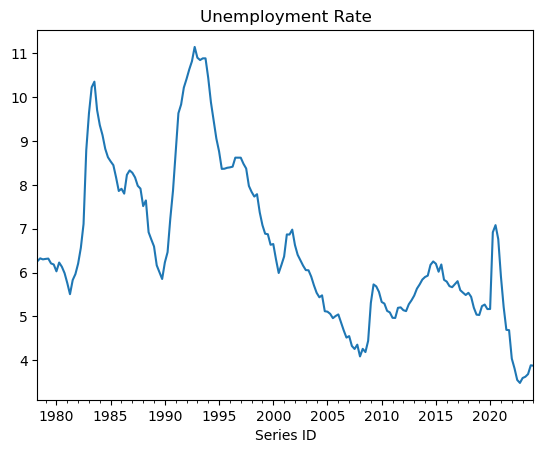

In [6]:

# unemployment rate
lfs_meta, lfs = get_abs_series(cat_id="6202.0", series_ids=["A84423043C", "A84423047L"])   
employed = lfs["A84423043C"]  # employed persons, thousands, seasonally adjusted
labour_force = lfs["A84423047L"]  # labour force, thousands, seasonally adjusted
ue_rate_m = ((1 - employed / labour_force) * 100).dropna()
U = monthly_to_quarterly(ue_rate_m)
U.plot(title="Unemployment Rate")

#### remaining data items (still to do)

In [7]:

# import prices
trade_meta, trade = get_abs_series(cat_id="6457.0", series_ids=["A2298279F"])
import_prices = trade["A2298279F"].dropna()  # Import Price Index by Balance of Payments, index, original
# Annual growth in consumer inport price deflator
cipd_growth = import_prices.pct_change(periods=4).dropna() * 100  

# quarterly real unit labour costs growth
nat_accounts_meta, nat_accounts = get_abs_series(cat_id="5206.0", series_ids='A2435279C')
rulcg = nat_accounts["A2435279C"].dropna()  # Unit labour cost - Real - Non-farm: Q/Q Percentage, Seas Adj

# inflation expectations
g3_meta, g3 = get_data("Inflation Expectations – G3")
expectations = g3["GBUSEXP"].dropna()  # Business inflation expectations – 3-months ahead, per cent per year
expectations.index = pd.PeriodIndex(expectations.index, freq="Q")

# global supply chain disruptions
# https://www.newyorkfed.org/research/policy/gscpi#/interactive
gscpi = pd.read_excel(
    "./NAIRU_INPUTS/gscpi_data.xls", sheet_name="GSCPI Monthly Data", index_col=0, parse_dates=True
)["GSCPI"]
gscpi = monthly_to_quarterly(gscpi)
gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")

# Australian Government 10-year bond yield
bond_yields = pd.read_excel(
    "./NAIRU_INPUTS/RBA_bonds.xls", index_col=0, parse_dates=True, skiprows=10
)
bond_yield = monthly_to_quarterly(bond_yields["FCMYGBAG10"])
# There is a missing value in Q2 2013, so we will interpolate it
new_by_index = pd.period_range(start=bond_yield.index[0], end=bond_yield.index[-1], freq="Q")
bond_yield = bond_yield.reindex(new_by_index)
print("Missing values in bond yield: ", bond_yield[bond_yield.isna()].index)
bond_yield = bond_yield.interpolate(method="linear", limit_area="inside")



Missing values in bond yield:  PeriodIndex(['2013Q2'], dtype='period[Q-DEC]')


## Data wrangling

In [8]:
START = pd.Period("1986Q1", freq="Q")

df = pd.DataFrame(
    {
        "TM": trimmed_mean,
        "UER": U,
        "CIPD": cipd_growth,
        "RULCG": rulcg,
        "EXP": expectations,
        "GSCPI": gscpi,
        "BOND_YIELD": bond_yield,
    }
)
df = df[df.index >= START]
df.isna().sum()  # How many NaNs in each column

TM             0
UER            0
CIPD           0
RULCG          1
EXP           14
GSCPI         48
BOND_YIELD     0
dtype: int64

## Bayesian model

In [9]:
# parameters for fitting the model
N_CORES: int = 4
SAMPLES: int = 10_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 1_000

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
}

In [10]:
# model data inputs
n_months = len(df)

In [11]:
# The actual model- based on formulas in RBA(2017) by Tom Cusbert.
model = pm.Model()
with model:
    
    # NAIRU is a Gaussian random walk - formula A3
    nairu_start = pm.Normal.dist(mu=5, sigma=2)
    nairu_innovation = pm.Normal("nairu_innovation", sigma=0.1)
    nairu = pm.GaussianRandomWalk(
        "nairu",
        mu=0,  # no drift in this model
        sigma=nairu_innovation,
        init_dist=nairu_start,
        steps=n_months,
    )

    # Inflation likelihood - formula A1


    # Unit labour cost growth likelihood - formula A2
    

    
    
